### Inverse Dynamics
```
The objective of inverse dynamics is to recover the applied force and contact force given the position, velocity and acceleration of the multi-joint system. 
```
- MuJoCo's soft contact model enable computationally efficient and numerically stable inverse dynamic computations
- Inverse dynamics play a key role in optimization algorithms arising in system identification, estimation and control.

In [1]:
import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
from mujoco_parser import *
from transformation import *
from slider import *

from utility import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.1]


#### Parse `Franka Emika Panda`

In [3]:
xml_path = '../asset/panda/franka_panda.xml'
env = MuJoCoParserClass(name='Panda',rel_xml_path=xml_path,verbose=True)

name:[Panda] dt:[0.002] HZ:[500]
n_qpos:[9] n_qvel:[9] n_qacc:[9] n_ctrl:[9]

n_body:[18]
 [0/18] [world] mass:[0.00]kg
 [1/18] [panda_base] mass:[0.00]kg
 [2/18] [panda_pedestal] mass:[60.86]kg
 [3/18] [panda_link_0] mass:[4.00]kg
 [4/18] [panda_link_1] mass:[3.00]kg
 [5/18] [panda_link_2] mass:[3.00]kg
 [6/18] [panda_link_3] mass:[2.00]kg
 [7/18] [panda_link_4] mass:[2.00]kg
 [8/18] [panda_link_5] mass:[2.00]kg
 [9/18] [panda_link_6] mass:[1.50]kg
 [10/18] [panda_link_7] mass:[0.50]kg
 [11/18] [right_hand] mass:[0.50]kg
 [12/18] [panda_right_gripper] mass:[0.30]kg
 [13/18] [panda_eef] mass:[0.00]kg
 [14/18] [panda_leftfinger] mass:[0.10]kg
 [15/18] [panda_finger_joint1_tip] mass:[0.01]kg
 [16/18] [panda_rightfinger] mass:[0.10]kg
 [17/18] [panda_finger_joint2_tip] mass:[0.01]kg
body_total_mass:[79.88]kg

n_geom:[26]
geom_names:['floor', 'pedestal_vis', 'panda_link_0_visual', 'panda_link_0_collision', 'panda_link_1_visual', 'panda_link_1_collision', 'panda_link_2_visual', 'panda_link_

#### Animate free-fall motion

In [6]:
# Buffers
time_list,qpos_list = [],[]
# Loop
env.reset(step=True)
env.init_viewer(transparent=True)
while env.is_viewer_alive():
    # Update
    env.step()
    # Append
    if env.loop_every(tick_every=10):
        time_list.append(env.get_sim_time())
        qpos_list.append(env.get_qpos_joints(joint_names=env.rev_joint_names))
    # Render
    if env.loop_every(tick_every=10):
        env.plot_time()
        env.plot_T()
        env.plot_links_between_bodies()
        env.plot_joint_axis(axis_len=0.05,alpha=1.0)
        env.render()
    # Terminate
    if env.get_sim_time() > 20: break
env.close_viewer()
print ("Done.")

Done.


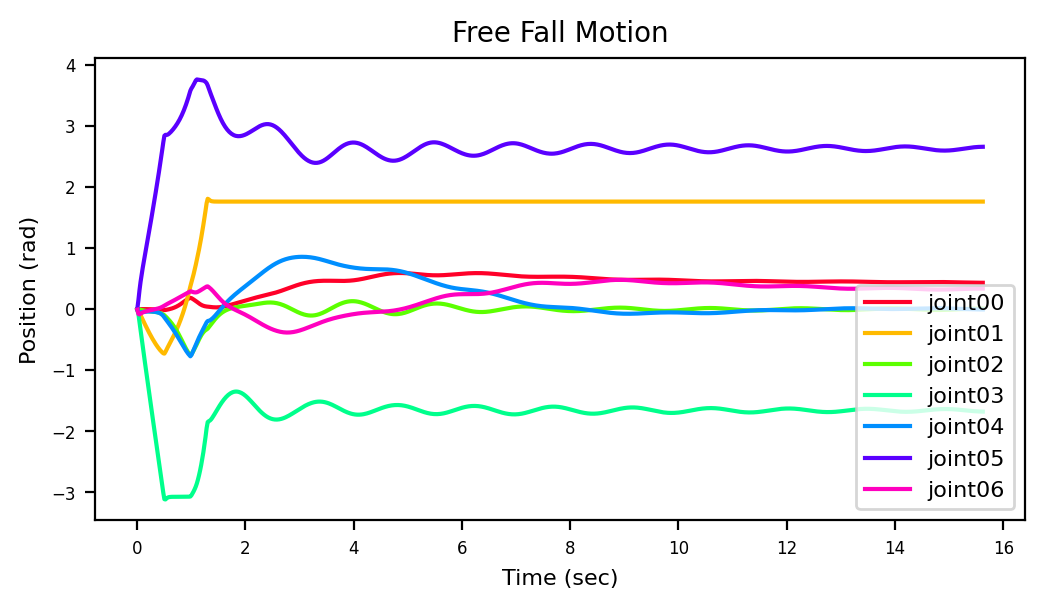

In [7]:
plt.figure(figsize=(6,3))
colors = get_colors(n_color=env.n_rev_joint)
for j_idx in range(env.n_rev_joint):
    plt.plot(np.array(time_list),np.array(qpos_list)[:,j_idx],
             '-',color=colors[j_idx],label='joint%02d'%(j_idx))
plt.xlabel('Time (sec)',fontsize=8)
plt.ylabel('Position (rad)',fontsize=8)
plt.legend(fontsize=8,loc='lower right')
plt.title('Free Fall Motion',fontsize=10)
plt.show()

#### `Computed torque method` without damping

In [8]:
# Buffers
time_list,qpos_list = [],[]
# Desired joint position
q_des = np.deg2rad([0,0,0,-90,0,90,0,0,0]) # 7dof + 2gripper
# Parameters
k_p = 1
k_d = 0 # no damping
# Reset
env.reset(step=True)
# Loop
env.init_viewer(transparent=True)
while env.is_viewer_alive():
    # Update
    qpos_curr = env.get_qpos()[env.ctrl_qpos_idxs] # current joint position
    qacc_des = k_p*(q_des - qpos_curr) - k_d*env.get_qvel()
    qfrc_inverse = env.solve_inverse_dynamics(qacc=qacc_des)
    env.step(ctrl=qfrc_inverse)
    # Append
    if env.loop_every(tick_every=10):
        time_list.append(env.get_sim_time())
        qpos_list.append(env.get_qpos_joints(joint_names=env.rev_joint_names))
    # Render
    if env.loop_every(tick_every=50):
        env.plot_time()
        env.plot_T()
        env.plot_links_between_bodies()
        env.plot_joint_axis(axis_len=0.05,alpha=1.0)
        env.render()
    # Terminate
    if env.get_sim_time() > 100: break
env.close_viewer()
print ("Done.")

KeyboardInterrupt: 

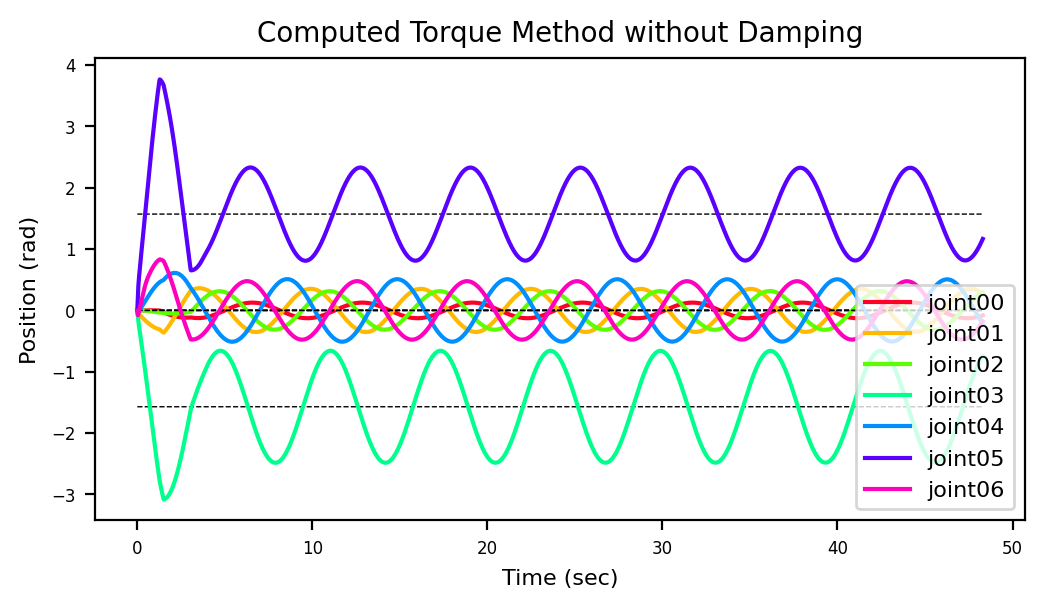

In [9]:
plt.figure(figsize=(6,3))
colors = get_colors(n_color=env.n_rev_joint)
for j_idx in range(env.n_rev_joint):
    plt.plot(np.array(time_list),q_des[j_idx]*np.ones(len(time_list)),
             '--',color='k',lw=1/2)
    plt.plot(np.array(time_list),np.array(qpos_list)[:,j_idx],
             '-',color=colors[j_idx],label='joint%02d'%(j_idx))
plt.xlabel('Time (sec)',fontsize=8)
plt.ylabel('Position (rad)',fontsize=8)
plt.legend(fontsize=8,loc='lower right')
plt.title('Computed Torque Method without Damping',fontsize=10)
plt.show()

#### `Computed torque method` with damping

In [12]:
# Buffers
time_list,qpos_list = [],[]
# Desired joint position
q_des = np.deg2rad([0,0,0,-90,0,90,0,0,0]) # 7dof + 2gripper
# Parameters
k_p = 1.2
k_d = 0.3 # with damping
# Reset
env.reset(step=True)
# Loop
env.init_viewer(transparent=True)
while env.is_viewer_alive():
    # Update
    qpos_curr = env.get_qpos()[env.ctrl_qpos_idxs] # current joint position
    qacc_des = k_p*(q_des - qpos_curr) - k_d*env.get_qvel()
    qfrc_inverse = env.solve_inverse_dynamics(qacc=qacc_des)
    env.step(ctrl=qfrc_inverse)
    # Append
    if env.loop_every(tick_every=10):
        time_list.append(env.get_sim_time())
        qpos_list.append(env.get_qpos_joints(joint_names=env.rev_joint_names))
    # Render
    if env.loop_every(tick_every=50):
        env.plot_time()
        env.plot_T()
        env.plot_links_between_bodies()
        env.plot_joint_axis(axis_len=0.05,alpha=1.0)
        env.render()
    # Terminate
    if env.get_sim_time() > 20: break
env.close_viewer()
print ("Done.")

Done.


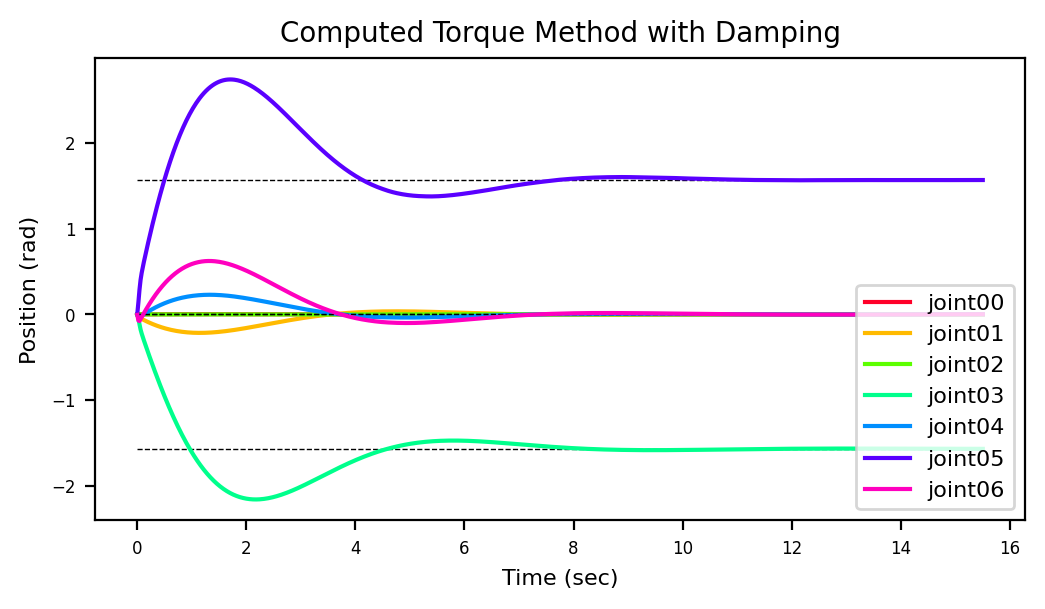

In [11]:
plt.figure(figsize=(6,3))
colors = get_colors(n_color=env.n_rev_joint)
for j_idx in range(env.n_rev_joint):
    plt.plot(np.array(time_list),q_des[j_idx]*np.ones(len(time_list)),
             '--',color='k',lw=1/2)
    plt.plot(np.array(time_list),np.array(qpos_list)[:,j_idx],
             '-',color=colors[j_idx],label='joint%02d'%(j_idx))
plt.xlabel('Time (sec)',fontsize=8)
plt.ylabel('Position (rad)',fontsize=8)
plt.legend(fontsize=8,loc='lower right')
plt.title('Computed Torque Method with Damping',fontsize=10)
plt.show()